In [4]:
%autosave 0

Autosave disabled


In [5]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from env import get_connection
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from scipy import stats
from wrangle import train_val_test


In [6]:
def acquire_data():
    url = get_connection('zillow')
    query = '''
            SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet,
                   taxvaluedollarcnt, yearbuilt, taxamount, fips
            FROM properties_2017
            JOIN propertylandusetype
                ON properties_2017.propertylandusetypeid = propertylandusetype.propertylandusetypeid
            WHERE propertylandusetype.propertylandusedesc = 'Single Family Residential';
            '''
    df = pd.read_sql(query, url)
    return df
df = acquire_data()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152863 entries, 0 to 2152862
Data columns (total 7 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   bedroomcnt                    float64
 1   bathroomcnt                   float64
 2   calculatedfinishedsquarefeet  float64
 3   taxvaluedollarcnt             float64
 4   yearbuilt                     float64
 5   taxamount                     float64
 6   fips                          float64
dtypes: float64(7)
memory usage: 115.0 MB


In [7]:
acquire_data()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0
...,...,...,...,...,...,...,...
2152858,4.0,3.0,2262.0,960756.0,2015.0,13494.52,6059.0
2152859,4.0,4.5,3127.0,536061.0,2014.0,6244.16,6059.0
2152860,0.0,0.0,NaN,208057.0,NaN,5783.88,6059.0
2152861,3.0,2.5,1974.0,424353.0,2015.0,5302.70,6059.0


In [8]:
df.shape

(2152863, 7)

In [9]:
df.isna().sum()

bedroomcnt                        11
bathroomcnt                       11
calculatedfinishedsquarefeet    8484
taxvaluedollarcnt                493
yearbuilt                       9337
taxamount                       4442
fips                               0
dtype: int64

since bedroomcnt and bathroomcnt and taxvaluedollarcnt has the least nulls values, I decide dropping it would not affect the data. With the other features containing high null values, I will have to impute those with the mean of all observations.

In [10]:
def clean_and_impute_data(df):
    # Drop rows with null values in specified columns
    columns_to_drop_null = ['bedroomcnt', 'bathroomcnt', 'taxvaluedollarcnt']
    df.dropna(subset=columns_to_drop_null, inplace=True)
    
    # Impute null values with means for specified columns
    columns_to_impute = ['calculatedfinishedsquarefeet', 'yearbuilt', 'taxamount']
    for column in columns_to_impute:
        mean_value = df[column].mean()
        df[column].fillna(mean_value, inplace=True)
    
    return df

cleaned_df = clean_and_impute_data(df)


In [11]:
df.shape  #a few observations has been dropped

(2152359, 7)

In [12]:
df.describe()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
count,2.152359e+06,2.152359e+06,2.152359e+06,2.152359e+06,2.152359e+06,2.152359e+06,2.152359e+06
mean,3.287807e+00,2.231119e+00,1.862871e+03,4.618968e+05,1.960951e+03,5.634944e+03,6.048375e+03
std,9.537961e-01,9.989155e-01,1.219797e+03,6.996774e+05,2.211522e+01,8.171396e+03,2.042839e+01
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.801000e+03,1.850000e+00,6.037000e+03
25%,3.000000e+00,2.000000e+00,1.258000e+03,1.881710e+05,1.949000e+03,2.537980e+03,6.037000e+03
50%,3.000000e+00,2.000000e+00,1.626000e+03,3.276710e+05,1.958000e+03,4.115480e+03,6.037000e+03
75%,4.000000e+00,3.000000e+00,2.204000e+03,5.345270e+05,1.975000e+03,6.407705e+03,6.059000e+03
max,2.500000e+01,3.200000e+01,9.525760e+05,9.842891e+07,2.016000e+03,1.337756e+06,6.111000e+03


In [13]:
df.info() #everything is float so it is good

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2152359 entries, 0 to 2152862
Data columns (total 7 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   bedroomcnt                    float64
 1   bathroomcnt                   float64
 2   calculatedfinishedsquarefeet  float64
 3   taxvaluedollarcnt             float64
 4   yearbuilt                     float64
 5   taxamount                     float64
 6   fips                          float64
dtypes: float64(7)
memory usage: 131.4 MB


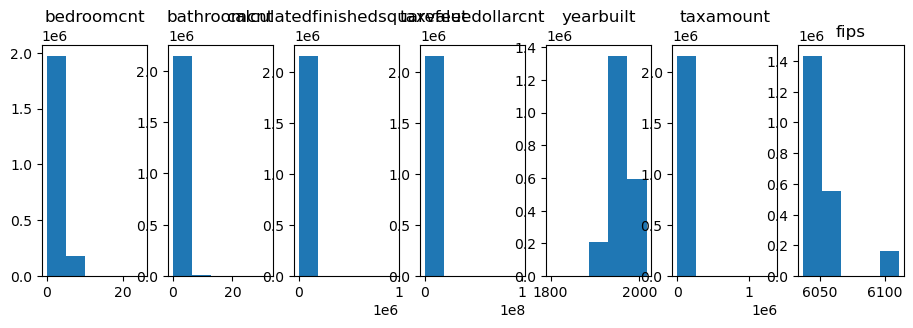

In [14]:
plt.figure(figsize=(16, 3))

# List of columns
cols = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'yearbuilt', 'taxamount', 'fips']

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1,10, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)

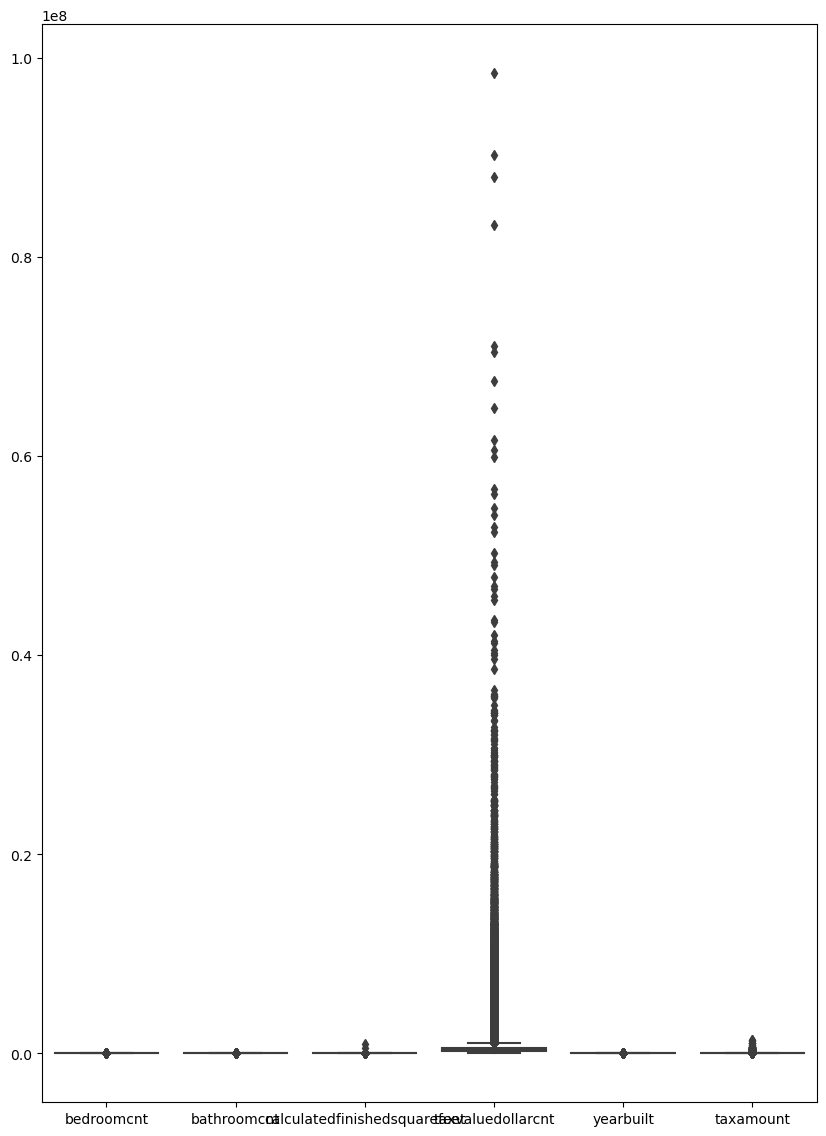

In [15]:


plt.figure(figsize=(10,14))

# Create boxplots for all but student_id.
sns.boxplot(data=df.drop(columns=['fips']))
plt.show()

In [16]:
import os
import pandas as pd
from env import get_connection  # Make sure these variables are defined in env.py



def get_zillow_data():
    filename = "zillow.csv"

    if os.path.isfile(filename):
        return pd.read_csv(filename, index_col=0)
    else:
        # Create the url
        url = get_connection('zillow')

        # Read the SQL query into a dataframe
        query = '''
                SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet,
                       taxvaluedollarcnt, yearbuilt, taxamount, fips
                FROM properties_2017
                JOIN propertylandusetype
                    ON properties_2017.propertylandusetypeid = propertylandusetype.propertylandusetypeid
                WHERE propertylandusetype.propertylandusedesc = 'Single Family Residential';
                '''
        df = pd.read_sql(query, url)

        # Write the dataframe to disk for later. Called "caching" the data for later.
        df.to_csv(filename)

        # Return the dataframe to the calling code
        return df

def wrangle_zillow():
    '''
    Read Zillow data from database, drop rows with NaN values,
    convert all columns to int64 data types, and return cleaned DataFrame.
    '''
    zillow = get_zillow_data()

    # Drop all rows with NaN values.
    df = zillow.dropna()

    # Convert all columns to int64 data types.
    df = df.astype('int')

    return df


In [17]:
df = wrangle_zillow()

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 638945 entries, 4 to 642712
Data columns (total 7 columns):
 #   Column                        Non-Null Count   Dtype
---  ------                        --------------   -----
 0   bedroomcnt                    638945 non-null  int64
 1   bathroomcnt                   638945 non-null  int64
 2   calculatedfinishedsquarefeet  638945 non-null  int64
 3   taxvaluedollarcnt             638945 non-null  int64
 4   yearbuilt                     638945 non-null  int64
 5   taxamount                     638945 non-null  int64
 6   fips                          638945 non-null  int64
dtypes: int64(7)
memory usage: 39.0 MB


In [19]:
#only fit scaling object to train data set
seed = 42

train, val_test = train_test_split(df, train_size = 0.8,
                                  random_state = seed)

val, test = train_test_split(val_test, train_size = 0.5,
                           random_state = seed)

train.shape, val.shape, test.shape

((511156, 7), (63894, 7), (63895, 7))

for col in df.columns[df.dtypes == 'float64']:
    plt.figure()
    sns.histplot(data = df, x=col)
    plt.title(f'Distribution of {col}')
    plt.show()

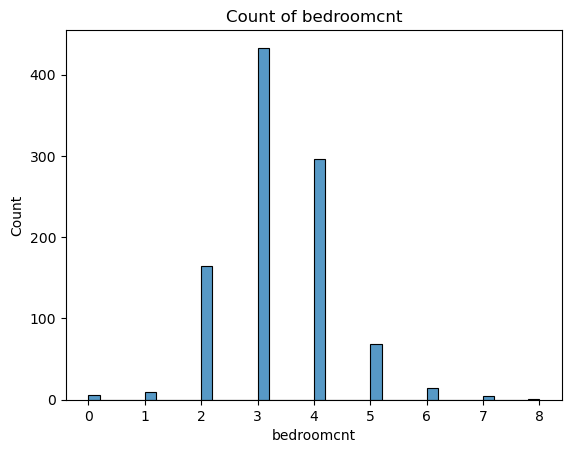

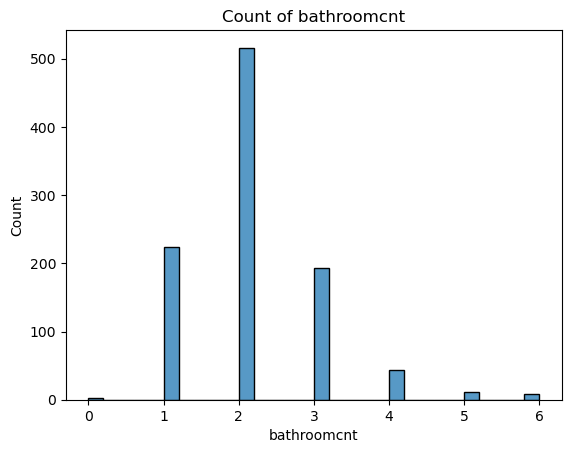

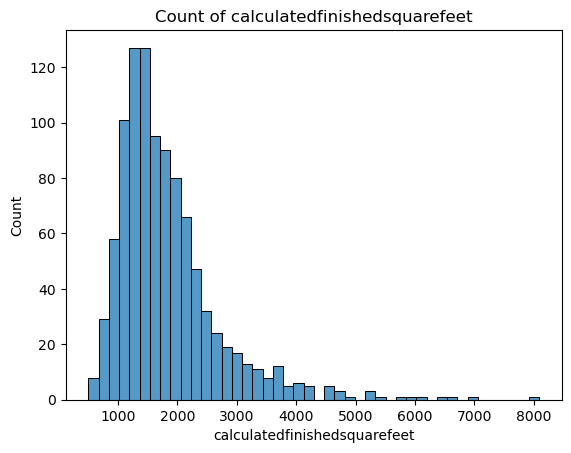

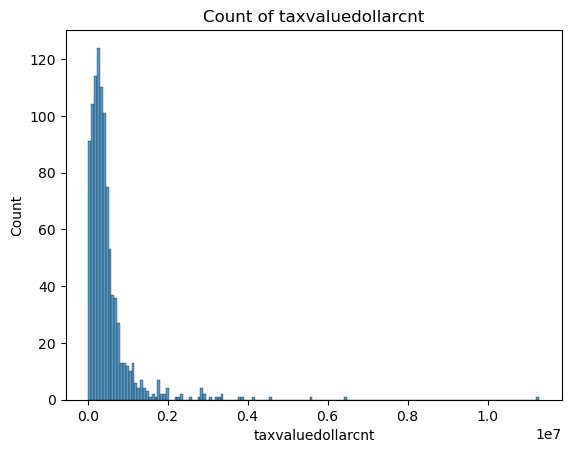

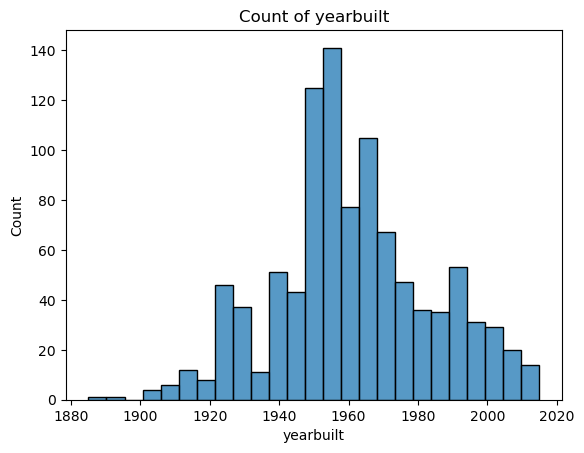

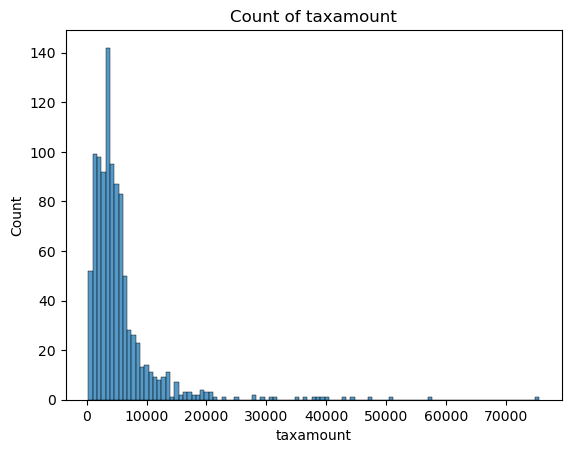

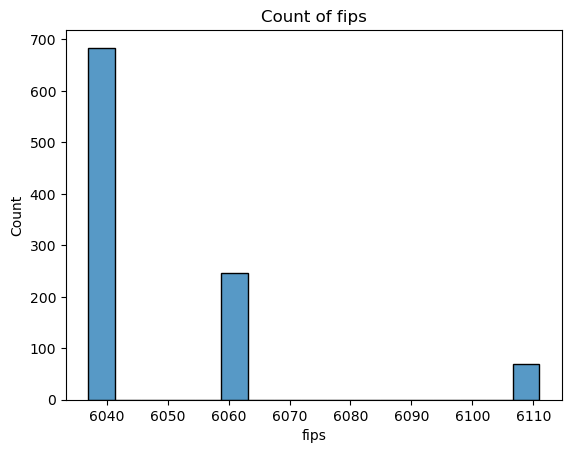

In [20]:
for col in df.columns[df.dtypes != 'object']:
    plt.figure()
    sns.histplot(data = df.sample(1000), x=col)
    plt.title(f'Count of {col}')
    plt.show()

In [21]:
train, val, test = train_val_test(df)
train.shape, val.shape, test.shape

((447261, 7), (95842, 7), (95842, 7))

Questions:

0. Does yearbuilt have a relationship with taxvaluedollarcnt?
0. Does squarefeeet have a relationship with taxvaluedollarcnt?
0. Does bedroomcnt have a relationship with taxvaluedollarcnt?

## Question 1 

Does year built have a relationship with tax?

year built are numerical and price are numerical, 

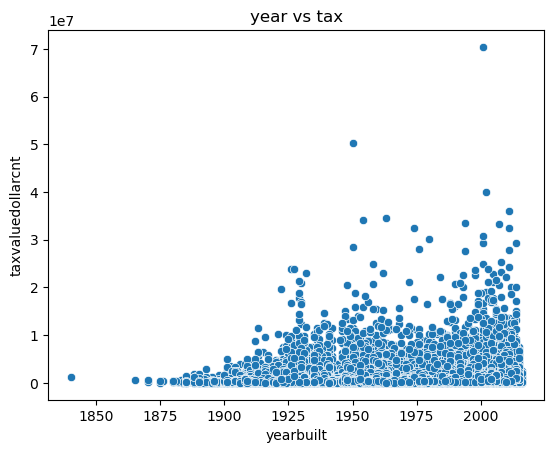

In [22]:
sns.scatterplot(data = train, x='yearbuilt', y='taxvaluedollarcnt')
plt.title("year vs tax")
plt.show() 


#consider turning the year into age by subtracting the current to the beginning

# Question 2 

does squarefeet have a relationshiop with taxvaluedollarcnt?

# Question 3

Does bedroom cnt have a relationship with taxvalueDollarcnt?

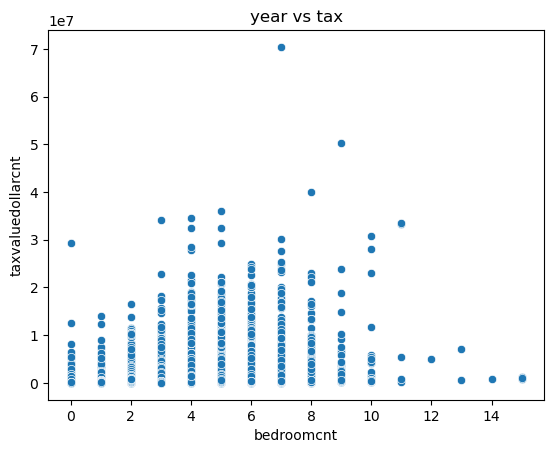

In [23]:
sns.scatterplot(data = train, x='bedroomcnt', y='taxvaluedollarcnt')
plt.title("year vs tax")
plt.show()

In [24]:
def plot_variable_pairs(df):
    sns.pairplot(df.sample(100))
    plt.show()


/opt/homebrew/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 69.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 41.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 75.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 52.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/seaborn/cat

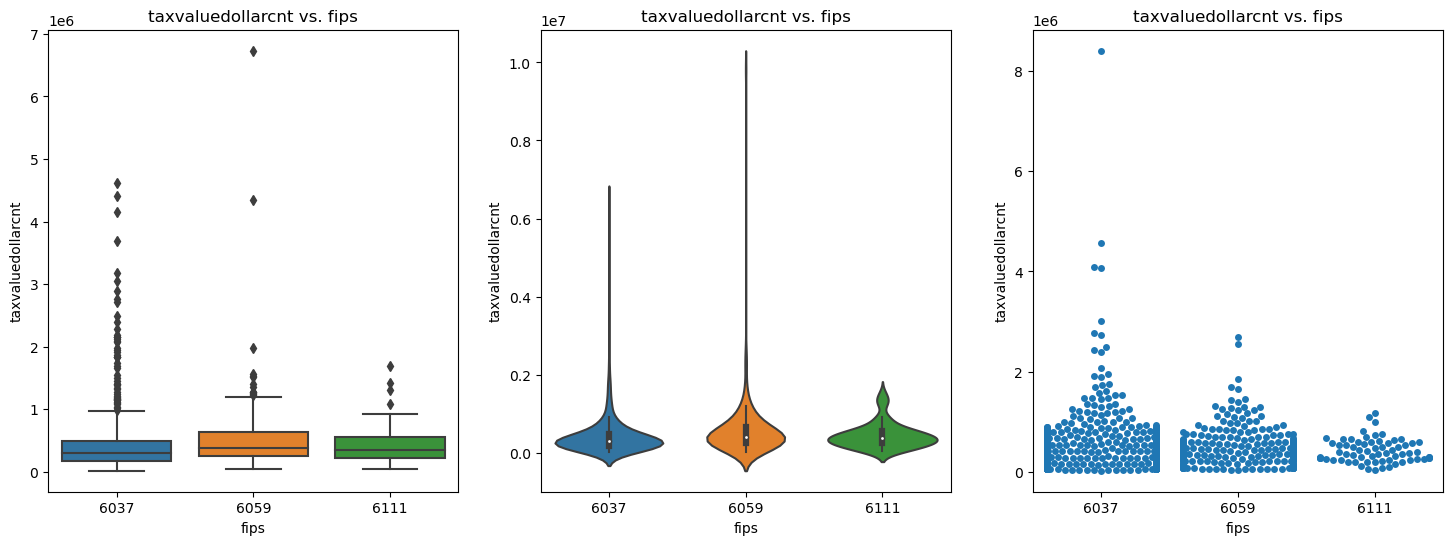

In [25]:

def plot_categorical_and_continuous_vars(df, categorical_var, continuous_var):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Box plot of categorical vs. continuous variable
    #use sample size
    sns.boxplot(x=categorical_var, y=continuous_var, data=df.sample(1000), ax=axes[0])
    axes[0].set_title(f'{continuous_var} vs. {categorical_var}')

    # Violin plot of categorical vs. continuous variable
    # use sample size
    sns.violinplot(x=categorical_var, y=continuous_var, data=df.sample(1000), ax=axes[1])
    axes[1].set_title(f'{continuous_var} vs. {categorical_var}')

     #Swarm plot of categorical vs. continuous variable, 
     #use sample size 
    sns.swarmplot(x=categorical_var, y=continuous_var, data=df.sample(1000), ax=axes[2])
    axes[2].set_title(f'{continuous_var} vs. {categorical_var}')


    plt.show()
    
categorical_var = 'fips'  
continuous_var = 'taxvaluedollarcnt'  

plot_categorical_and_continuous_vars(df, categorical_var, continuous_var)

What independent variables are correlated with the dependent variable, home value? 



Make sure to document your takeaways from visualizations and statistical tests as well as the decisions you make throughout your process.

Explore your dataset with any other visualizations you think will be helpful.

In [ ]:


Which independent variables are correlated with other independent variables (bedrooms, bathrooms, year built, square feet)?

# Calculate pairwise correlations between selected independent variables
selected_vars = ['bedrooms', 'bathrooms', 'year_built', 'square_feet']
selected_corr = df[selected_vars].corr()

# Plot a heatmap of correlations
plt.figure(figsize=(8, 6))
sns.heatmap(selected_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Pairwise Correlations')
plt.show()